In [1]:
from mlgrad.risk import ERisk, ERiskGB
from mlgrad.loss import SquareErrorLoss, ErrorLoss
from mlgrad.model import LinearFuncModel, SigmaNeuronModel, FFNetworkModel, \
                        FFNetworkFuncModel, SigmaNeuronModelLayer, LinearModel
from mlgrad.func import SoftPlus, Sqrt, Sigmoidal, HingeSqrt, Arctang, Absolute

from mlgrad import erm_fg, erm_irgd, fg, erm_fg, erisk
# from mlgrad.regr import m_regression_irls
# from mlgrad.af import averaging_function
# from mlgrad.weights import MWeights

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt

import sys
print(sys.version)

3.9.13 (main, Jun  8 2022, 09:45:57) 
[GCC 11.3.0]


In [3]:
X, Y = datasets.load_boston(return_X_y=True)
N = len(X)
print(X.shape, X.dtype)
print(Y.shape, Y.dtype)
# print(Y)

(506, 13) float64
(506,) float64


/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fu

In [4]:
print(Y.shape, X.shape)
print(Y.dtype, X.dtype)

(506,) (506, 13)
float64 float64


In [5]:
X_o = preprocessing.robust_scale(np.ascontiguousarray(X)) 
Y_o = Y.copy() #preprocessing.robust_scale(Y)

In [6]:
# print(Y_o)

In [7]:
from mlgrad.boost.gb_regression import gb_fit, gb_fit_agg

In [8]:
def new_model(N):
    mod = SigmaNeuronModel(Sigmoidal(0.5), N)
    mod.init_param()
    return mod

m = 40
lfm = gb_fit(X_o, Y_o, new_model, h=0.01, tol=1.0e-8, n_iter=m)
lfm, lvals = lfm.complex_model, lfm.lvals
# print(np.asarray(lfm.weights))

In [9]:
alpha=0.99
lfm_agg = gb_fit_agg(X_o, Y_o, new_model, alpha=alpha, h=0.01, tol=1.0e-8, n_iter=m)
lfm_agg, lvals_agg = lfm_agg.complex_model, lfm_agg.lvals
# print(np.asarray(lfm_agg.weights))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


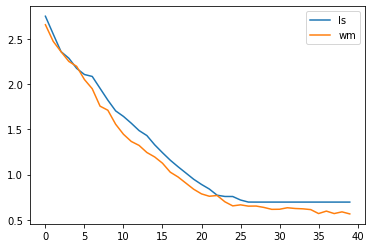

In [10]:
plt.plot(np.log(lvals), label='ls')
plt.plot(np.log(lvals_agg), label='wm')
plt.legend()
plt.savefig('boston_%.0f_%s_lvals.eps' % (alpha*100,m))
plt.show()

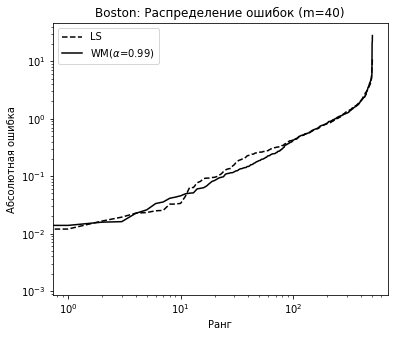

In [11]:
plt.figure(figsize=(6,5))
plt.xlabel('Ранг')
plt.ylabel('Абсолютная ошибка')
plt.title("Boston: Распределение ошибок (m=%s)" % m)
plt.loglog(sorted([abs(lfm(X_o[k])-Y_o[k]) for k in range(N)]), linestyle='--', color='k', label='LS')
plt.loglog(sorted([abs(lfm_agg(X_o[k])-Y_o[k]) for k in range(N)]), 
           linestyle='-', color='k', label=r"WM($\alpha$=%s)" % alpha)
plt.savefig('boston_%.0f_%s_errors.eps' % (alpha*100,m))
plt.legend()
plt.show()

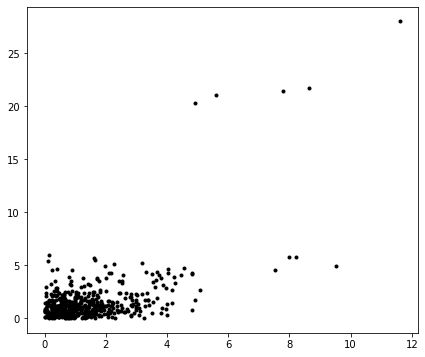

In [12]:
plt.figure(figsize=(7,6))
plt.scatter(np.abs(lfm.evaluate_all(X_o)-Y_o), np.abs(lfm_agg.evaluate_all(X_o)-Y_o), s=9, c='k')
plt.savefig('boston_%.0f_%s_errors_box.eps' % (alpha*100,m))
plt.show()

In [13]:
Y_ls = np.array([lfm(Xk) for Xk in X_o])
Y_agg = np.array([lfm_agg(Xk) for Xk in X_o])

In [14]:
err_ls = np.abs(Y_o - Y_ls)
err_wm = np.abs(Y_o - Y_agg)

acc_ls = np.mean(err_ls)
acc_wm = np.mean(err_wm)
var_ls = np.mean(np.abs(err_ls - acc_ls))
var_wm = np.mean(np.abs(err_wm - acc_wm))

print(acc_ls, acc_wm)
print(var_ls, var_wm)

1.4370685120871878 1.55759795629731
0.9601715577078604 1.1368704608455442


In [15]:
err_ls = np.abs(Y_o - Y_ls)
err_wm = np.abs(Y_o - Y_agg)
acc_ls = np.median(err_ls)
acc_wm = np.median(err_wm)
var_ls = np.median(np.abs(err_ls - acc_ls))
var_wm = np.median(np.abs(err_wm - acc_wm))

print(acc_ls, acc_wm)
print(var_ls, var_wm)

1.0388153925171029 1.0796686199935621
0.6133465226821482 0.6004190961322333


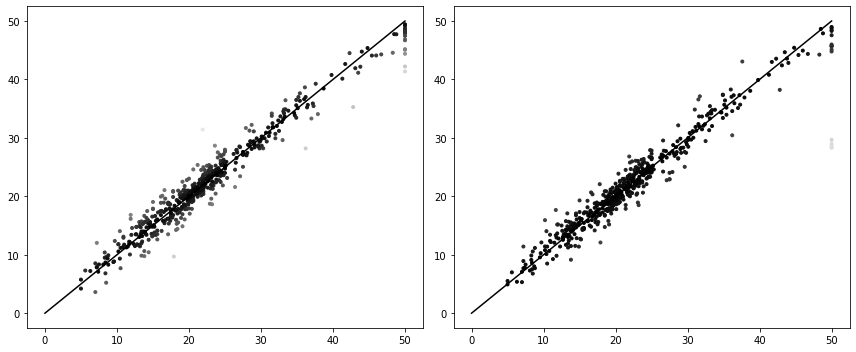

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Y_o, Y_ls, c=np.abs(Y_o-Y_ls), s=9, cmap=plt.cm.Greys_r)
plt.plot([0,50], [0,50], color='k')
plt.subplot(1,2,2)
plt.scatter(Y_o, Y_agg, c=np.abs(Y_o-Y_agg), s=9, cmap=plt.cm.Greys_r)
plt.plot([0,50], [0,50], color='k')
plt.subplot(1,2,2)
plt.tight_layout()
plt.show()